# Advanced: Convert Posterior Distributions from EMCEE

**IMPORTANT**: this tutorial assumes basic knowledge (and uses a file resulting from) the [emcee tutorial](./emcee.ipynb).

**NOTE**: a bug in the latex labels when *converting to univariate distributions* was fixed in 2.3.12.  Running this notebook on earlier versions will raise an error near the end.

## Setup

Let's first make sure we have the latest version of PHOEBE 2.3 installed (uncomment this line if running in an online notebook session such as colab).

In [1]:
#!pip install -I "phoebe>=2.3,<2.4"

In [2]:
import phoebe
from phoebe import u # units
import numpy as np

logger = phoebe.logger('error')

/home/kyle/.local/lib/python3.8/site-packages/phoebe/backend/universe.py:312: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.irrad_method is not 'none' and not ignore_effects:


We'll then start with the bundle from the end of the [emcee tutorial](./emcee.ipynb).  If you're running this notebook locally, you will need to run that first to create the `emcee_advanced_tutorials.bundle` file that we will use here.

In [3]:
b = phoebe.load('emcee_advanced_tutorials.bundle')

# how posteriors are represented

The emcee solution object contains all the samples from all chains during the MCMC run.  This is then "trimmed" based on the set or passed values of `burnin`, `thin`, and `lnprob_cutoff` to create a [distl MVSamples](https://distl.readthedocs.io/en/latest/api/MVSamples/) object - which is capable of plotting the histogram representation of all these samples as a corner plot, while still retaining (and ultimately drawing from) the full underlying set of samples.  This is the most "true" representation of the underlying information, but requires maintaining the full set of "trimmed" samples and can be expensive for a large number of walkers/iterations.

We can access the underlying [distl MVSamples](https://distl.readthedocs.io/en/latest/api/MVSamples/) object with [b.get_distribution_collection](../api/phoebe.frontend.bundle.Bundle.get_distribution_collection.md) and can see that it has a [dc.samples](https://distl.readthedocs.io/en/latest/api/MVSamples.samples/) property containing this underlying data.

In [4]:
dc, twigs = b.get_distribution_collection(solution='emcee_sol')

In [5]:
dc

<distl.mvsamples samples=[[ 7.15168747e+00  8.02629767e+01  9.90851430e-02  2.02854433e+00
   1.26189339e+01 -1.27199644e+08]
 [ 7.15654998e+00  8.03399431e+01  9.90133330e-02  2.01032325e+00
   1.25883610e+01 -1.76984469e+08]
 [ 7.07497371e+00  8.02986974e+01  9.87952962e-02  1.96272573e+00
   1.25291228e+01 -6.42943044e+08]
 ...
 [ 7.24406209e+00  8.05633837e+01  9.93773171e-02  2.08544425e+00
   1.26720328e+01 -5.34400482e+09]
 [ 6.52122362e+00  7.87978215e+01  9.89177725e-02  1.83471187e+00
   1.23060634e+01 -1.07814580e+09]
 [ 6.63361726e+00  7.90481330e+01  9.97118670e-02  1.88291727e+00
   1.23762303e+01 -1.03411095e+09]] weights=None bw_method=None units=[Unit("solRad"), Unit("deg"), Unit("d"), Unit("solRad"), Unit("W"), Unit(dimensionless)] labels=['sma@binary', 'incl@binary', 't0_supconj@binary', 'requiv@primary', 'pblum@lc01', 'sigmas_lnf@lc01'] labels_latex=['$a_\\mathrm{ binary }$', '$i_\\mathrm{ binary }$', '$t_{0, \\mathrm{ supconj }, \\mathrm{ binary } }$', '$R_{ \\math

We could convert this object manually using distl, using [dc.to_mvgaussian](https://distl.readthedocs.io/en/latest/api/MVSamples.to_mvgaussian/), for example.  This is much more lightweight, as it only stores the means and covariance matrix, but is really only fair if the samples can be well-represented by a multivariate gaussian.

In [6]:
dc.to_mvgaussian()

<distl.mvgaussian mean=[ 6.92383538e+00  7.97522596e+01  9.95422479e-02  1.98185075e+00
  1.25330359e+01 -1.35936897e+09] cov=[[ 3.49734467e-02  9.59369889e-02 -7.95604253e-06  8.98383653e-03
   1.43444076e-02  3.30368082e+07]
 [ 9.59369889e-02  2.88228036e-01 -2.64019628e-05  2.31630707e-02
   3.81600846e-02  1.18541447e+08]
 [-7.95604253e-06 -2.64019628e-05  1.33524121e-07  2.39414826e-07
  -5.62473024e-07 -8.81257195e+04]
 [ 8.98383653e-03  2.31630707e-02  2.39414826e-07  2.84593710e-03
   4.27729814e-03  7.43440972e+06]
 [ 1.43444076e-02  3.81600846e-02 -5.62473024e-07  4.27729814e-03
   6.61302230e-03  1.52395392e+07]
 [ 3.30368082e+07  1.18541447e+08 -8.81257195e+04  7.43440972e+06
   1.52395392e+07  3.10506799e+18]] allow_singular=False units=[Unit("solRad"), Unit("deg"), Unit("d"), Unit("solRad"), Unit("W"), Unit(dimensionless)] labels=['sma@binary', 'incl@binary', 't0_supconj@binary', 'requiv@primary', 'pblum@lc01', 'sigmas_lnf@lc01'] labels_latex=['$a_\\mathrm{ binary }$', '$

PHOEBE provides an interface to do these conversions (using distl) under-the-hood so that all the plotting and adopting infrastructure still works seemlesly.  This brings us to the `distributions_convert` parameter.

# distributions_convert parameter

The `distributions_convert` parameter (or as an override keyword argument) will convert the underlying [distl MVSamples](https://distl.readthedocs.io/en/latest/api/MVSamples/) object to the desired distribution type whenever calling [adopt_solution](../api/phoebe.frontend.bundle.Bundle.adopt_solution.md), [get_distribution_collection](../api/phoebe.frontend.bundle.Bundle.get_distribution_collection.md), [sample_distribution_collection](../api/phoebe.frontend.bundle.Bundle.sample_distribution_collection.md), [uncertainties_from_distribution_collection](../api/phoebe.frontend.bundle.Bundle.uncertainties_from_distribution_collection.md), [plot_distribution_collection](../api/phoebe.frontend.bundle.Bundle.plot_distribution_collection.md), or [plot](../phoebe.parameters.ParameterSet.plot.md) (with `style='corner'` or `'failed'`).

If we examine the `distributions_convert` parameter (in the emcee solution), we can see its description and available choices.

In [7]:
print(b.get_parameter(qualifier='distributions_convert', solution='emcee_sol'))

Parameter: distributions_convert@emcee_sol@solution
                       Qualifier: distributions_convert
                     Description: type of distribution to use when calling adopt_solution, get_distribution_collection, or plot. mvsamples: chains are stored directly and used for sampling with a KDE generated on-the-fly to compute probabilities.  mvhistogram: chains are binned according to distributions_bins and stored as an n-dimensional histogram.  mvgaussian: a multivariate gaussian is fitted to the samples, use only if distribution is sufficiently represented by gaussians.  samples: a univariate representation of mvsamples.  histogram: a univariate representation of mvhistogram.  gaussian: a univariate representation of mvgaussian.
                           Value: mvsamples
                         Choices: mvsamples, mvhistogram, mvgaussian, samples, histogram, gaussian
                  Constrained by: 
                      Constrains: None
                      Related 

If we don't pass `distributions_convert` to `plot`, then the value from the parameter will be used.  In this case, it will keep the distribution as a multivariate samples.

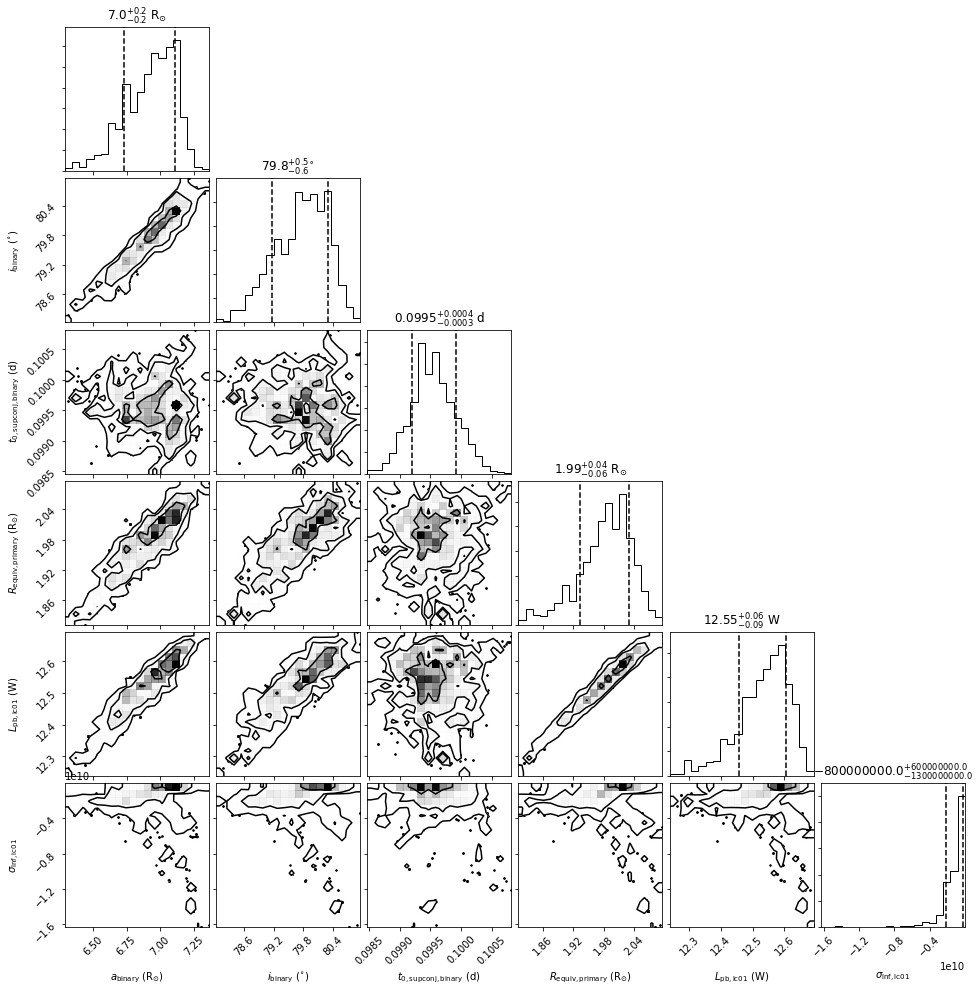

In [8]:
_ = b.plot(solution='emcee_sol', style='corner', show=True)

By converting to [MVHistogram](https://distl.readthedocs.io/en/latest/api/MVHistogram/), the data is stored as an N-dimensional histogram.  In this case, with a 6 parameters and a default of 20 bins per dimension (when `distributions_convert` is set to `'mvhistogram'` or `'histogram'`, a new `distributions_bins` parameter becomes visible to override the default), this is actually more expensive to store than the underlying samples.  But in cases with few parameters and a large number of walkers/iterations, the binned version may be cheaper to manage.

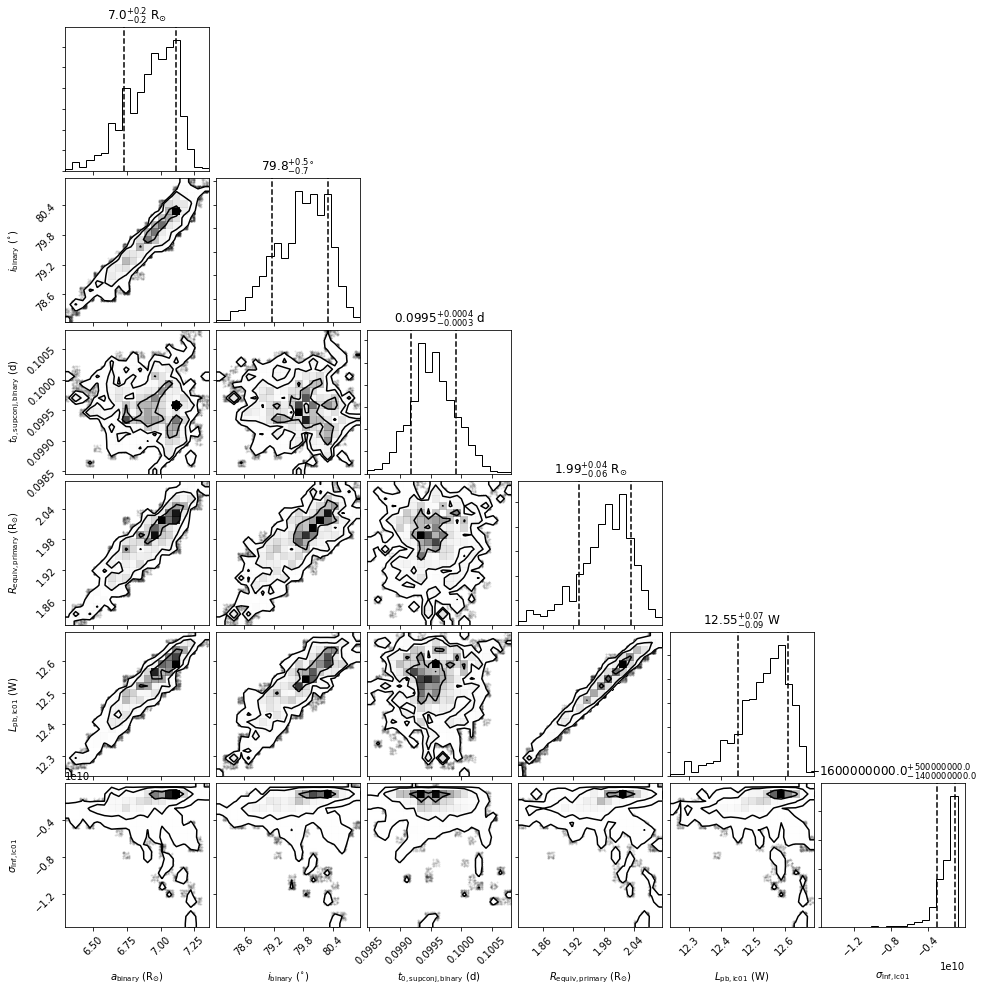

In [9]:
_ = b.plot(solution='emcee_sol', style='corner', 
           distributions_convert='mvhistogram', show=True)

By converting to [MVGaussian](https://distl.readthedocs.io/en/latest/api/MVGaussian/), the data is stored as means and a covariance matrix.  This is extremely cheap to store, but should **only** be used if the underlying distribution is gaussian (probably not the case here, especially for the last parameter).

/home/kyle/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py:660: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


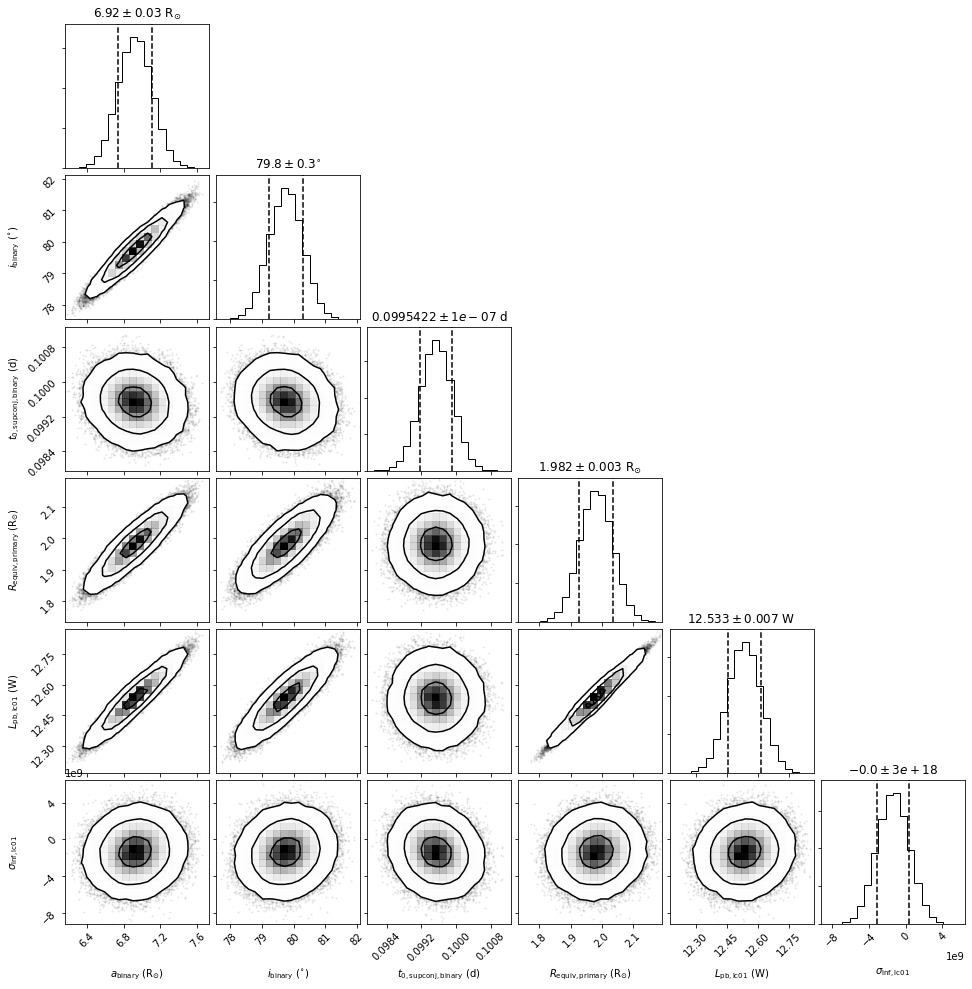

In [10]:
_ = b.plot(solution='emcee_sol', style='corner', 
           distributions_convert='mvgaussian', show=True)

Even cheaper yet, we can convert to non-multivariate distribution types and drop information about the covariances between parameters.  Here if we convert to a collection of [Gaussian](https://distl.readthedocs.io/en/latest/api/Gaussian/) distributions, only the means and sigmas are stored.

**NOTE**: a bug in the latex labels when *converting to univariate distributions* was fixed in 2.3.12.  Running this notebook on earlier versions will raise an error near the end

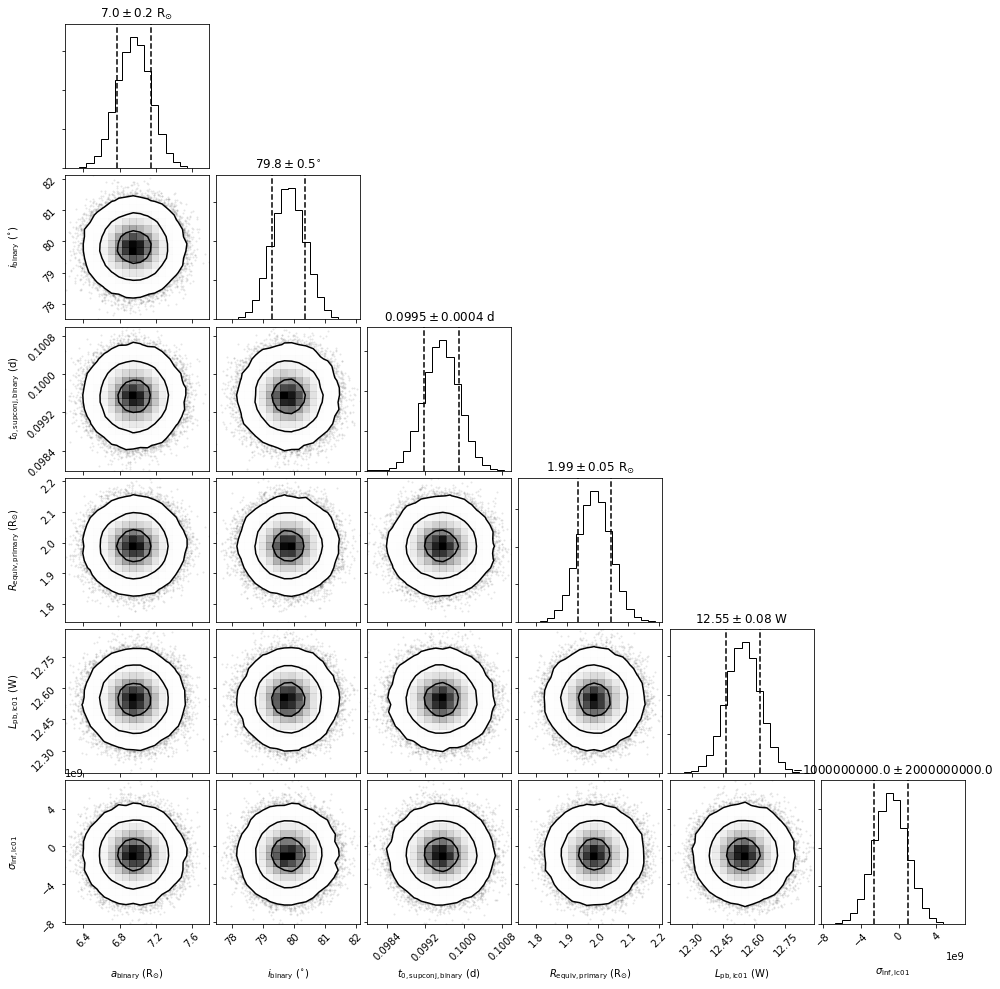

In [11]:
_ = b.plot(solution='emcee_sol', style='corner', 
           distributions_convert='gaussian', show=True)

If we look at the actual [distl DistributionCollection](https://distl.readthedocs.io/en/latest/api/DistributionCollection/) object, we can see that it now contains a list of independent gaussian distributions.

In [12]:
dc, twigs = b.get_distribution_collection(solution='emcee_sol', distributions_convert='gaussian')

In [13]:
print(dc)

In [14]:
print(dc.dists)

[<distl.gaussian loc=6.958541786093118 scale=0.18697292440961447 unit=solRad label=sma@binary label_latex=$a_\mathrm{ binary }$>, <distl.gaussian loc=79.82254753177895 scale=0.5367568734280519 unit=deg label=incl@binary label_latex=$i_\mathrm{ binary }$>, <distl.gaussian loc=0.09953062651353055 scale=0.00036533339020260023 unit=d label=t0_supconj@binary label_latex=$t_{0, \mathrm{ supconj }, \mathrm{ binary } }$>, <distl.gaussian loc=1.9897096755705612 scale=0.05333620996213503 unit=solRad label=requiv@primary label_latex=$R_{ \mathrm{ equiv }, \mathrm{ primary } }$>, <distl.gaussian loc=12.546688345281828 scale=0.08130354776155045 unit=W label=pblum@lc01 label_latex=$L_\mathrm{ pb, lc01 }$>, <distl.gaussian loc=-820896250.2435328 scale=1761753163.0200856 unit= label=sigmas_lnf@lc01 label_latex=$\sigma_\mathrm{ lnf, lc01 }$>]


## See Also

See the following for even more advanced use cases of emcee.

* [Advanced: continuing emcee from a previous run](./emcee_continue_from.ipynb)
* [Advanced: resampling emcee from a previous run](./emcee_resample.ipynb)